In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C://duh/Thinkful/Thinkful/Exercises/Medium_AggregatedData.csv')

In [3]:
df.head()

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,...,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
3,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,...,technology,Technology,166125.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104
4,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,...,robotics,Robotics,9103.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104


In [4]:
df.drop(['audioVersionDurationSec', 'codeBlock', 'codeBlockCount',
         'collectionId', 'imageCount', 'isSubscriptionLocked', 'linksCount',
         'postId', 'readingTime', 'responsesCreatedCount',
         'socialRecommendsCount', 'tagsCount', 'publicationfacebookPageName',
         'publicationfollowerCount', 'publicationpublicEmail',
         'publicationdomain', 'publicationslug', 'publicationtwitterUsername',
         'userId', 'userName', 'usersFollowedByCount',
         'usersFollowedCount'], 1, inplace=True)
df.drop(['createdDatetime', 'latestPublishedDate', 'vote', 'scrappedDate',
         'latestPublishedDatetime', 'slug', 'name', 'postCount', 'bio',
         'firstPublishedDatetime', 'uniqueSlug', 'updatedDate',
         'updatedDatetime'], 1, inplace=True)
df.drop(df.index[df.language != 'en'], inplace=True)
df = df.reset_index(drop=True)
authorindex = []
for author in df.author.unique():
    if df.text.where(df.author == author).nunique() >= 100:
        authorindex.append(author)
authorindex = authorindex[:10]
df = df.query('author in @authorindex')
df = df[:int(len(df)/100)]
df = df.reset_index(drop=True)
nlp = spacy.load('en')
df['doc'] = None
df['bow'] = None

del authorindex

sentences = pd.DataFrame()

In [5]:
df.head()

,createdDate,firstPublishedDate,language,recommends,subTitle,text,title,totalClapCount,url,wordCount,publicationdescription,publicationname,publicationtags,tag_name,author,doc,bow
0,2017-10-26,2017-10-26,en,5,NaN,How Machine Learning is Revolutionizing Digita...,How Machine Learning is Revolutionizing Digita...,11,https://medium.com/s/story/how-machine-learnin...,627,NaN,NaN,NaN,Artificial Intelligence,Yves Mulkers,None,None
1,2017-10-26,2017-10-26,en,5,NaN,How Machine Learning is Revolutionizing Digita...,How Machine Learning is Revolutionizing Digita...,11,https://medium.com/s/story/how-machine-learnin...,627,NaN,NaN,NaN,Big Data,Yves Mulkers,None,None
2,2017-10-26,2017-10-26,en,5,NaN,How Machine Learning is Revolutionizing Digita...,How Machine Learning is Revolutionizing Digita...,11,https://medium.com/s/story/how-machine-learnin...,627,NaN,NaN,NaN,Body Language,Yves Mulkers,None,None
3,2018-03-02,2018-03-02,en,0,PRODUCTS & SERVICES,"Tech & Telecom news — Mar 2, 2018\nPRODUCTS & ...","Tech & Telecom news — Mar 2, 2018",0,https://medium.com/s/story/tech-telecom-news-m...,525,The most interesting news in technology and te...,Tech / Telecom News,"TECHNOLOGY,TELECOM,VIDEO,CLOUD,ARTIFICIAL INTE...",Spotify,C Gavilanes,None,None
4,2018-03-02,2018-03-02,en,0,PRODUCTS & SERVICES,"Tech & Telecom news — Mar 2, 2018\nPRODUCTS & ...","Tech & Telecom news — Mar 2, 2018",0,https://medium.com/s/story/tech-telecom-news-m...,525,The most interesting news in technology and te...,Tech / Telecom News,"TECHNOLOGY,TELECOM,VIDEO,CLOUD,ARTIFICIAL INTE...",Advertising,C Gavilanes,None,None


In [6]:
df.shape

(75, 17)

In [7]:
for x in range(len(df.text)):
    if x % 250 == 0:
        print("Processing row {}".format(x))
    #df.text[x] = re.sub(df.title[x], '', df.text[x])
    df.text[x] = df.text[x].lower()
    df.text[x] = re.sub('https://*.*?\\n', ' ', df.text[x])
    df.text[x] = re.sub('http://*.*?\\n', ' ', df.text[x])
    df.text[x] = re.sub('\\n', ' ', df.text[x])
    df.text[x] = re.sub('bibliography.*', '', df.text[x])
    df.text[x] = re.sub('[%s]' % re.escape(string.punctuation), '', df.text[x])
    df.text[x] = re.sub('\w*\d\w*', '', df.text[x])
    df.text[x] = re.sub('’', '', df.text[x])
    df.text[x] = re.sub('—', ' ', df.text[x])
    df.text[x] = re.sub('”', '', df.text[x])
    df.text[x] = re.sub('“', '', df.text[x])
    df.text[x] = re.sub('‘', '', df.text[x])
    df.text[x] = re.sub('€', '', df.text[x])
    df.text[x] = re.sub('…', ' ', df.text[x])
    df.text[x] = re.sub('\ \ ', ' ', df.text[x])
    df.text[x] = df.text[x].strip()
    if df.text[x] == '':
        df.drop([x], inplace=True)
        df = df.reset_index(drop=True)

Processing row 0


In [8]:
df.text[74]

'google brain now medical brain leader jeff dean  image credit fortune googles medical brain can now predict probability of death in hospitals in clinics soon this story was first published on cognitive world on june  we know that artificial intelligence will transform healthcare as we know it its science fiction come alive here as google ai can help doctors predict when patients might die the ai is now better at predicting death than hospitals googles medical brain team is now training its ai to predict the death risk among hospital patients and theres lots of buzz what this will do to our healthcare systems in a paper published in nature in may of from googles team it says of its predictive algorithm these models outperformed traditional clinicallyused predictive models in all cases we believe that this approach can be used to create accurate and scalable predictions for a variety of clinical scenarios bloomberg first reported the story and went on to explain that google has a new al

In [9]:
df.head()

,createdDate,firstPublishedDate,language,recommends,subTitle,text,title,totalClapCount,url,wordCount,publicationdescription,publicationname,publicationtags,tag_name,author,doc,bow
0,2017-10-26,2017-10-26,en,5,NaN,how machine learning is revolutionizing digita...,How Machine Learning is Revolutionizing Digita...,11,https://medium.com/s/story/how-machine-learnin...,627,NaN,NaN,NaN,Artificial Intelligence,Yves Mulkers,None,None
1,2017-10-26,2017-10-26,en,5,NaN,how machine learning is revolutionizing digita...,How Machine Learning is Revolutionizing Digita...,11,https://medium.com/s/story/how-machine-learnin...,627,NaN,NaN,NaN,Big Data,Yves Mulkers,None,None
2,2017-10-26,2017-10-26,en,5,NaN,how machine learning is revolutionizing digita...,How Machine Learning is Revolutionizing Digita...,11,https://medium.com/s/story/how-machine-learnin...,627,NaN,NaN,NaN,Body Language,Yves Mulkers,None,None
3,2018-03-02,2018-03-02,en,0,PRODUCTS & SERVICES,tech telecom news mar products services vide...,"Tech & Telecom news — Mar 2, 2018",0,https://medium.com/s/story/tech-telecom-news-m...,525,The most interesting news in technology and te...,Tech / Telecom News,"TECHNOLOGY,TELECOM,VIDEO,CLOUD,ARTIFICIAL INTE...",Spotify,C Gavilanes,None,None
4,2018-03-02,2018-03-02,en,0,PRODUCTS & SERVICES,tech telecom news mar products services vide...,"Tech & Telecom news — Mar 2, 2018",0,https://medium.com/s/story/tech-telecom-news-m...,525,The most interesting news in technology and te...,Tech / Telecom News,"TECHNOLOGY,TELECOM,VIDEO,CLOUD,ARTIFICIAL INTE...",Advertising,C Gavilanes,None,None


In [10]:
df.shape

(75, 17)

In [11]:
for x in range(len(df.text)):
    df.doc[x] = nlp(df.text[x])
    sents = [[sent, df.author[x]] for sent in df.doc[x].sents]
    sentences = sentences.append(sents, ignore_index=True)

In [12]:
sentences.head()

,0,1
0,"(how, machine, learning, is, revolutionizing, ...",Yves Mulkers
1,"(then, you, can, not, afford, to, wait, for, t...",Yves Mulkers
2,"(ai, and, machine, learning, ml, machines, tha...",Yves Mulkers
3,"(cognitive, functions, are, still, a, dream, o...",Yves Mulkers
4,"(ml, mimics, how, the, human, cognitive, syste...",Yves Mulkers


In [13]:
sentences.shape

(501, 2)

In [14]:
def bag_of_words(text):
    
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

def bow_features(sentences, common_words):
    
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        for word in words:
            df.loc[i, word] += 1
        
        if i % 1000 == 0:
            print("Processing row {}".format(i))
            
    return df

In [15]:
for x in range(len(df.text)):
    df.bow[x] = bag_of_words(df.doc[x])

In [16]:
df.head()

,createdDate,firstPublishedDate,language,recommends,subTitle,text,title,totalClapCount,url,wordCount,publicationdescription,publicationname,publicationtags,tag_name,author,doc,bow
0,2017-10-26,2017-10-26,en,5,NaN,how machine learning is revolutionizing digita...,How Machine Learning is Revolutionizing Digita...,11,https://medium.com/s/story/how-machine-learnin...,627,NaN,NaN,NaN,Artificial Intelligence,Yves Mulkers,"(how, machine, learning, is, revolutionizing, ...","[ml, business, machine, technology, datum, ent..."
1,2017-10-26,2017-10-26,en,5,NaN,how machine learning is revolutionizing digita...,How Machine Learning is Revolutionizing Digita...,11,https://medium.com/s/story/how-machine-learnin...,627,NaN,NaN,NaN,Big Data,Yves Mulkers,"(how, machine, learning, is, revolutionizing, ...","[ml, business, machine, technology, datum, ent..."
2,2017-10-26,2017-10-26,en,5,NaN,how machine learning is revolutionizing digita...,How Machine Learning is Revolutionizing Digita...,11,https://medium.com/s/story/how-machine-learnin...,627,NaN,NaN,NaN,Body Language,Yves Mulkers,"(how, machine, learning, is, revolutionizing, ...","[ml, business, machine, technology, datum, ent..."
3,2018-03-02,2018-03-02,en,0,PRODUCTS & SERVICES,tech telecom news mar products services vide...,"Tech & Telecom news — Mar 2, 2018",0,https://medium.com/s/story/tech-telecom-news-m...,525,The most interesting news in technology and te...,Tech / Telecom News,"TECHNOLOGY,TELECOM,VIDEO,CLOUD,ARTIFICIAL INTE...",Spotify,C Gavilanes,"(tech, telecom, news, , mar, , products, ser...","[story, new, app, company, mobile, service, an..."
4,2018-03-02,2018-03-02,en,0,PRODUCTS & SERVICES,tech telecom news mar products services vide...,"Tech & Telecom news — Mar 2, 2018",0,https://medium.com/s/story/tech-telecom-news-m...,525,The most interesting news in technology and te...,Tech / Telecom News,"TECHNOLOGY,TELECOM,VIDEO,CLOUD,ARTIFICIAL INTE...",Advertising,C Gavilanes,"(tech, telecom, news, , mar, , products, ser...","[story, new, app, company, mobile, service, an..."


In [17]:
common_words = set()
for x in range(len(df.text)):
    common_words.update(df.bow[x])

In [20]:
word_counts = bow_features(sentences, common_words)
'''
print('A')
a = bow_features(sentences[:int(len(sentences)/10)].reset_index(drop=True), common_words)
print('B')
b = bow_features(sentences[int(len(sentences)/10):int(len(sentences)/10)+4500].reset_index(drop=True), common_words)
print('C')
c = bow_features(sentences[int(len(sentences)/10)+4500:int(len(sentences)/10)+9000].reset_index(drop=True), common_words)
print('D')
d = bow_features(sentences[int(len(sentences)/10)+9000:int(len(sentences)/10)+13500].reset_index(drop=True), common_words)
print('E')
e = bow_features(sentences[int(len(sentences)/10)+13500:int(len(sentences)/10)+18000].reset_index(drop=True), common_words)
print('F')
f = bow_features(sentences[int(len(sentences)/10)+18000:int(len(sentences)/10)+22500].reset_index(drop=True), common_words)
print('G')
g = bow_features(sentences[int(len(sentences)/10)+22500:int(len(sentences)/10)+27000].reset_index(drop=True), common_words)
print('H')
h = bow_features(sentences[int(len(sentences)/10)+27000:int(len(sentences)/10)+31500].reset_index(drop=True), common_words)
print('I')
i = bow_features(sentences[int(len(sentences)/10)+31500:int(len(sentences)/10)+36000].reset_index(drop=True), common_words)
print('J')
j = bow_features(sentences[int(len(sentences)/10)+36000:].reset_index(drop=True), common_words)

word_counts = word_counts.append([a, b, c, d, e, f, g, h, i, j], ignore_index=True)
del a, b, c, d, e, f, g, h, i, j
'''

Processing row 0


"\nprint('A')\na = bow_features(sentences[:int(len(sentences)/10)].reset_index(drop=True), common_words)\nprint('B')\nb = bow_features(sentences[int(len(sentences)/10):int(len(sentences)/10)+4500].reset_index(drop=True), common_words)\nprint('C')\nc = bow_features(sentences[int(len(sentences)/10)+4500:int(len(sentences)/10)+9000].reset_index(drop=True), common_words)\nprint('D')\nd = bow_features(sentences[int(len(sentences)/10)+9000:int(len(sentences)/10)+13500].reset_index(drop=True), common_words)\nprint('E')\ne = bow_features(sentences[int(len(sentences)/10)+13500:int(len(sentences)/10)+18000].reset_index(drop=True), common_words)\nprint('F')\nf = bow_features(sentences[int(len(sentences)/10)+18000:int(len(sentences)/10)+22500].reset_index(drop=True), common_words)\nprint('G')\ng = bow_features(sentences[int(len(sentences)/10)+22500:int(len(sentences)/10)+27000].reset_index(drop=True), common_words)\nprint('H')\nh = bow_features(sentences[int(len(sentences)/10)+27000:int(len(senten

In [21]:
word_counts.head()

,whittaker,spoken,purchase,discussion,reutersmurad,inefficient,precisely,course,digital,efficiently,...,zero,support,accurate,passersby,implicit,fed,neighbour,hyperempower,text_sentence,text_source
0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,"(how, machine, learning, is, revolutionizing, ...",Yves Mulkers
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,"(then, you, can, not, afford, to, wait, for, t...",Yves Mulkers
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(ai, and, machine, learning, ml, machines, tha...",Yves Mulkers
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(cognitive, functions, are, still, a, dream, o...",Yves Mulkers
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(ml, mimics, how, the, human, cognitive, syste...",Yves Mulkers


In [22]:
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0,
                                                   stratify=Y)

In [23]:
X_norm = normalize(X)

X_pca = PCA(.95).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(random_state=0).fit_predict(X_pca)

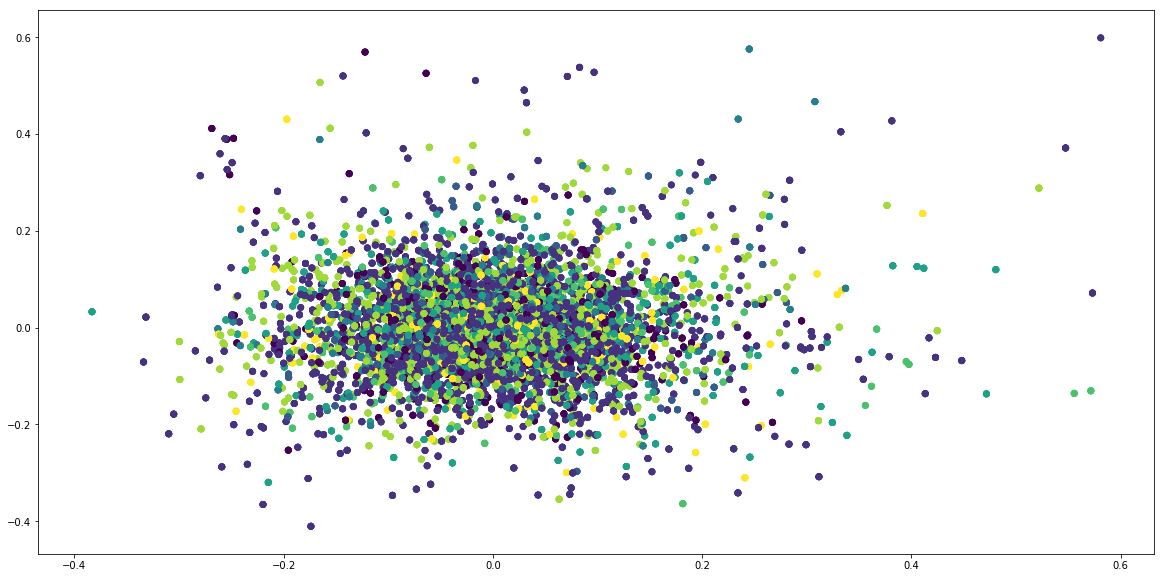

In [27]:
plt.figure(figsize=(20,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.scatter(X_pca[:, 2], X_pca[:, 3], c=y_pred)
plt.scatter(X_pca[:, 4], X_pca[:, 5], c=y_pred)
plt.scatter(X_pca[:, 6], X_pca[:, 7], c=y_pred)
plt.scatter(X_pca[:, 8], X_pca[:, 9], c=y_pred)
plt.scatter(X_pca[:, 10], X_pca[:, 11], c=y_pred)
plt.scatter(X_pca[:, 12], X_pca[:, 13], c=y_pred)
plt.scatter(X_pca[:, 14], X_pca[:, 15], c=y_pred)
plt.scatter(X_pca[:, 16], X_pca[:, 17], c=y_pred)
plt.scatter(X_pca[:, 18], X_pca[:, 19], c=y_pred)
plt.scatter(X_pca[:, 20], X_pca[:, 21], c=y_pred)
plt.scatter(X_pca[:, 22], X_pca[:, 23], c=y_pred)
plt.scatter(X_pca[:, 24], X_pca[:, 25], c=y_pred)
plt.scatter(X_pca[:, 26], X_pca[:, 27], c=y_pred)
plt.scatter(X_pca[:, 28], X_pca[:, 29], c=y_pred)
plt.scatter(X_pca[:, 30], X_pca[:, 31], c=y_pred)
plt.scatter(X_pca[:, 32], X_pca[:, 33], c=y_pred)
plt.scatter(X_pca[:, 34], X_pca[:, 35], c=y_pred)
plt.scatter(X_pca[:, 36], X_pca[:, 37], c=y_pred)
plt.scatter(X_pca[:, 38], X_pca[:, 39], c=y_pred)
plt.scatter(X_pca[:, 40], X_pca[:, 41], c=y_pred)
plt.scatter(X_pca[:, 42], X_pca[:, 43], c=y_pred)
plt.scatter(X_pca[:, 44], X_pca[:, 45], c=y_pred)
plt.scatter(X_pca[:, 46], X_pca[:, 47], c=y_pred)
plt.scatter(X_pca[:, 48], X_pca[:, 49], c=y_pred)
plt.scatter(X_pca[:, 50], X_pca[:, 51], c=y_pred)
plt.scatter(X_pca[:, 52], X_pca[:, 53], c=y_pred)
plt.scatter(X_pca[:, 54], X_pca[:, 55], c=y_pred)
plt.scatter(X_pca[:, 56], X_pca[:, 57], c=y_pred)
plt.scatter(X_pca[:, 58], X_pca[:, 59], c=y_pred)
plt.scatter(X_pca[:, 60], X_pca[:, 61], c=y_pred)
plt.scatter(X_pca[:, 62], X_pca[:, 63], c=y_pred)
plt.scatter(X_pca[:, 64], X_pca[:, 65], c=y_pred)
plt.scatter(X_pca[:, 66], X_pca[:, 67], c=y_pred)
plt.scatter(X_pca[:, 68], X_pca[:, 69], c=y_pred)
plt.scatter(X_pca[:, 70], X_pca[:, 71], c=y_pred)
plt.scatter(X_pca[:, 72], X_pca[:, 73], c=y_pred)
plt.scatter(X_pca[:, 74], X_pca[:, 75], c=y_pred)
plt.scatter(X_pca[:, 76], X_pca[:, 77], c=y_pred)
plt.scatter(X_pca[:, 78], X_pca[:, 79], c=y_pred)
plt.scatter(X_pca[:, 80], X_pca[:, 81], c=y_pred)
plt.scatter(X_pca[:, 82], X_pca[:, 83], c=y_pred)
plt.scatter(X_pca[:, 84], X_pca[:, 85], c=y_pred)
plt.scatter(X_pca[:, 86], X_pca[:, 87], c=y_pred)
plt.scatter(X_pca[:, 88], X_pca[:, 89], c=y_pred)
plt.scatter(X_pca[:, 90], X_pca[:, 91], c=y_pred)
plt.scatter(X_pca[:, 92], X_pca[:, 93], c=y_pred)
plt.scatter(X_pca[:, 94], X_pca[:, 95], c=y_pred)
plt.scatter(X_pca[:, 96], X_pca[:, 97], c=y_pred)
plt.scatter(X_pca[:, 98], X_pca[:, 99], c=y_pred)

plt.show()

In [25]:
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
        
print('Training score: ', lr.score(X_train, y_train))
print('Test score: ', lr.score(X_test, y_test))

Training score:  1.0
Test score:  1.0


In [26]:
svm = SVC(kernel='linear')
train = svm.fit(X_train, y_train)

print('Training score: ', svm.score(X_train, y_train))
print('Test score: ', svm.score(X_test, y_test))

Training score:  1.0
Test score:  0.9751243781094527


In [24]:
X_pca.shape

(501, 100)

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.5, 
                             min_df=2, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True 
                            )

In [ ]:
sentences[int(len(sentences)/10)+36000:]